# Initial wordnet WN18

It had 18 relation, 41,024 unique entities and 220,924 triples.
[Data can be found here](http://www.thespermwhale.com/jaseweston/papers/ebrm_mlj.pdf)

WN18RR has removed the reverse relationships based on [this paper](http://www.thespermwhale.com/jaseweston/papers/ebrm_mlj.pdf)

As WordNet is composed of words with different meanings, here we describe its entities by the concatenation of the word, its part-of-speech tag (’NN’ for noun, ’VB’ for verb, ’JJ’ for adjective and ’RB’ for adverb) and a number indicating which sense it refers to i.e. score_NN1_is the entity encoding the first meaning of the noun “score”.


Check out the code by [Ivana](https://github.com/ibalazevic/HypER) and also [the KGE list](https://github.com/thunlp/KRLPapers) and [the sota](http://nlpprogress.com/english/relation_prediction.html).

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)


train = pd.read_csv('./text/train.txt', sep='\t', header=None)
valid = pd.read_csv('./text/valid.txt', sep='\t', header=None)
test = pd.read_csv('./text/test.txt', sep='\t', header=None)
all_ = pd.concat([train, valid, test])

unique_ents = sorted(list(set(all_[0].unique().tolist() + all_[2].unique().tolist())))
unique_rels = sorted(all_[1].unique().tolist())

# General Info

In [26]:
print("Number of triples")
print("Train: %d (%0.2f %%) " % (train.shape[0], 100*train.shape[0]/float(all_.shape[0])))
print("Valid: %d (%0.2f %%) " % (valid.shape[0], 100*valid.shape[0]/float(all_.shape[0])))
print("Test: %d (%0.2f %%) " % (test.shape[0], 100*test.shape[0]/float(all_.shape[0])))
print("\n")
print("Unique Entities: %d" % len(unique_ents))
print("Unique Relations: %d" % len(unique_rels))

Number of triples
Train: 86835 (93.37 %) 
Valid: 3034 (3.26 %) 
Test: 3134 (3.37 %) 


Unique Entities: 41105
Unique Relations: 11


In [32]:
train2 = train.copy(deep=True)
train2['Label'] = ["Train" for i in range(train2.shape[0])]
valid2 = valid.copy(deep=True)
valid2['Label'] = ["Valid" for i in range(valid2.shape[0])]
test2 = test.copy(deep=True)
test2['Label'] = ["Test" for i in range(test.shape[0])]
all2 = pd.concat([train2, valid2, test2])

# Plot Distribution of Relations

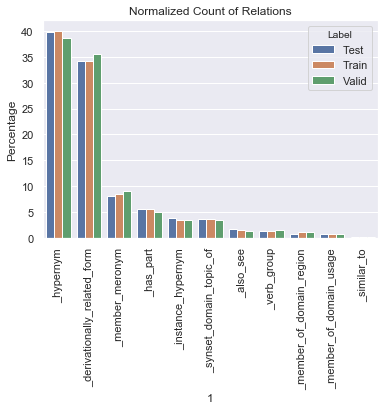

In [60]:
normalized_counts = (all2.groupby(['Label'])[1]
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index())
g = sns.barplot(x=1, 
                hue='Label', 
                y="Percentage",
                data=normalized_counts)
g.set_title("Normalized Count of Relations")
_ = plt.setp(g.get_xticklabels(), rotation=90)  # Rotate labels


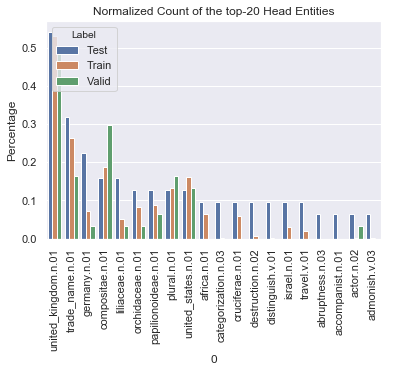

In [73]:
normalized_counts = (all2.groupby(['Label'])[0]
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index())
keep_n = 20
keeped_ind = normalized_counts[0].values[:keep_n]
normalized_counts = normalized_counts[normalized_counts[0].isin(keeped_ind)]
g = sns.barplot(x=0, 
                hue='Label', 
                y="Percentage",
                data=normalized_counts)
g.set_title("Normalized Count of the top-%d Head Entities" % keep_n)
_ = plt.setp(g.get_xticklabels(), rotation=90)  # Rotate labels

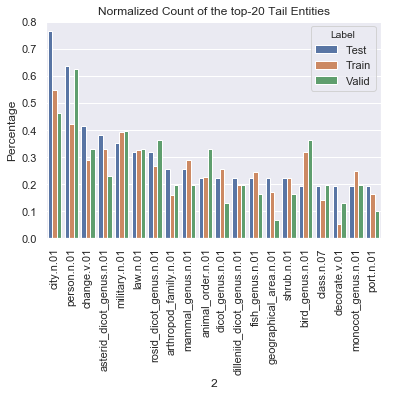

In [78]:
normalized_counts = (all2.groupby(['Label'])[2]
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index())
keep_n = 20
keeped_ind = normalized_counts[2].values[:keep_n]
normalized_counts = normalized_counts[normalized_counts[2].isin(keeped_ind)]
g = sns.barplot(x=2, 
                hue='Label', 
                y="Percentage",
                data=normalized_counts)
g.set_title("Normalized Count of the top-%d Tail Entities" % keep_n)
_ = plt.setp(g.get_xticklabels(), rotation=90)  # Rotate labels

# Simple networkx approaches

In [165]:
import networkx as nx
import heapq

def nonedges(G,u):  #a generator with (u,v) for every non neighbor v
    for v in nx.non_neighbors(G, u):
        yield (u, v)

# Create one network per-relation
networks = []
for rel in unique_rels:
#     g = nx.DiGraph()
#     for node in unique_ents:
#         g.add_node(node)
#     g.add_edges_from()
    g = nx.from_pandas_edgelist(train[train[1] == rel],
                                            source=0, target=2)
    for node in unique_ents:
        if not(g.has_node(node)):
            g.add_node(node)
    networks.append(g)

train_G = nx.from_pandas_edgelist(train, source=0, target=2, edge_attr=1, 
                        create_using=nx.MultiGraph)
valid_G = nx.from_pandas_edgelist(valid, source=0, target=2, edge_attr=1, 
                        create_using=nx.MultiGraph)
test_G = nx.from_pandas_edgelist(test, source=0, target=2, edge_attr=1, 
                        create_using=nx.MultiGraph)
all_G = nx.from_pandas_edgelist(all2, source=0, target=2, edge_attr=1, 
                        create_using=nx.MultiGraph)


# Generate aa ,jc , ra and pa scores for the train edges.
4 Features for each network (relation)
Resulting in 44 features in total.
Use a random forest/decision tree to classify it

Negative sampling of one edge not foun in train, valid or test.

In [176]:
import tqdm

def get_pred(graph, head, tail, func=nx.adamic_adar_index):
    try: 
        return [item for item in func(graph, [(head, tail)])][0][2]
    except ArithmeticError:
        return 0
    
def get_preds(cur_network, head_true, tail_true):
    aa = get_pred(cur_network, head_true, tail_true)
    jc = get_pred(cur_network, head_true, tail_true, nx.jaccard_coefficient)
    ra = get_pred(cur_network, head_true, tail_true, nx.resource_allocation_index)
    pa = get_pred(cur_network, head_true, tail_true, nx.preferential_attachment)
    return np.array([aa, jc, ra, pa])

X_train = []
y_train = []
ns = 1
for head_true, tail_true, type_dic in tqdm.tqdm_notebook(train_G.edges(data=True)):
    #print(head_true)
    for tail_false in nx.non_neighbors(all_G, head_true):
        break
    for i, cur_network in enumerate(networks):
        
    #     cn = get_pred(cur_network, head_true, tail_true, nx.cn_soundarajan_hopcroft)
    #     wi = get_pred(cur_network, head_true, tail_true, nx.within_inter_cluster)
    #     ra2 = get_pred(cur_network, head_true, tail_true, nx.ra_index_soundarajan_hopcroft)
        if i == 0:
            a = get_preds(cur_network, head_true, tail_true)
            a_false = get_preds(cur_network, head_true, tail_false)
        else:
            a = np.concatenate([a, get_preds(cur_network, head_true, tail_true)])
            a_false = np.concatenate([a_false, get_preds(cur_network, head_true, 
                                                         tail_false)])
    X_train.append(a)
    y_train.append(1)
    X_train.append(a_false)
    y_train.append(-1)
        
    #print(a)

# Fit the classifier

In [177]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dc = RandomForestClassifier(max_depth = 10,
                            n_estimators=100,
                            random_state= 42,
                            n_jobs=-1)
#DecisionTreeClassifier(max_depth=20)
dc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# Test results on "balanced" valid

In [178]:
X_valid = []
y_valid = []
for head_true, tail_true, type_dic in tqdm.tqdm_notebook(valid_G.edges(data=True)):
    #cur_net_id = unique_rels.index(type_dic[1])
    #cur_network = networks[cur_net_id]
    for tail_false in nx.non_neighbors(all_G, head_true):
        break
    for i, cur_network in enumerate(networks):
        
    #     cn = get_pred(cur_network, head_true, tail_true, nx.cn_soundarajan_hopcroft)
    #     wi = get_pred(cur_network, head_true, tail_true, nx.within_inter_cluster)
    #     ra2 = get_pred(cur_network, head_true, tail_true, nx.ra_index_soundarajan_hopcroft)
        if i == 0:
            a = get_preds(cur_network, head_true, tail_true)
            a_false = get_preds(cur_network, head_true, tail_false)
        else:
            a = np.concatenate([a, get_preds(cur_network, head_true, tail_true)])
            a_false = np.concatenate([a_false, get_preds(cur_network, head_true, 
                                                         tail_false)])
    X_valid.append(a)
    y_valid.append(1)
    X_valid.append(a_false)
    y_valid.append(-1)

In [179]:
from sklearn.metrics import classification_report, confusion_matrix
preds = dc.predict(X_valid)
print(classification_report(y_valid, preds))
print(confusion_matrix(y_valid, preds))

              precision    recall  f1-score   support

          -1       0.60      0.86      0.70      3034
           1       0.75      0.42      0.54      3034

   micro avg       0.64      0.64      0.64      6068
   macro avg       0.67      0.64      0.62      6068
weighted avg       0.67      0.64      0.62      6068

[[2597  437]
 [1755 1279]]


# Test on balanced test

In [180]:
X_test = []
y_test = []
for head_true, tail_true, type_dic in tqdm.tqdm_notebook(test_G.edges(data=True)):
    #cur_net_id = unique_rels.index(type_dic[1])
    #cur_network = networks[cur_net_id]
    for tail_false in nx.non_neighbors(all_G, head_true):
        break
    for i, cur_network in enumerate(networks):
        
    #     cn = get_pred(cur_network, head_true, tail_true, nx.cn_soundarajan_hopcroft)
    #     wi = get_pred(cur_network, head_true, tail_true, nx.within_inter_cluster)
    #     ra2 = get_pred(cur_network, head_true, tail_true, nx.ra_index_soundarajan_hopcroft)
        if i == 0:
            a = get_preds(cur_network, head_true, tail_true)
            a_false = get_preds(cur_network, head_true, tail_false)
        else:
            a = np.concatenate([a, get_preds(cur_network, head_true, tail_true)])
            a_false = np.concatenate([a_false, get_preds(cur_network, head_true, 
                                                         tail_false)])
    X_test.append(a)
    y_test.append(1)
    X_test.append(a_false)
    y_test.append(-1)

In [181]:
preds = dc.predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

          -1       0.60      0.85      0.70      3134
           1       0.74      0.43      0.55      3134

   micro avg       0.64      0.64      0.64      6268
   macro avg       0.67      0.64      0.62      6268
weighted avg       0.67      0.64      0.62      6268

[[2649  485]
 [1778 1356]]


In [182]:
## Get all possible feature vectors

In [189]:
len(unique_ents)*(len(unique_ents)-1)/float(2)

844789960.0

In [ ]:
from itertools import combinations
ranks = []
feat_dict = {}
for head_true, tail_true, type_dic in tqdm.tqdm_notebook(test_G.edges(data=True)):
    all_feats = []
    tail_true_ind = unique_ents.index(tail_true)
    for tail_all in unique_ents:
        try:
            a = feat_dict[head_true + "_" + tail_all]
        except KeyError:
            try:
                a = feat_dict[tail_all + "_" + head_true]
            except KeyError:
                for i, cur_network in enumerate(networks):
                    if i == 0:
                        a = get_preds(cur_network, head_true, tail_all)
                    else:
                        a = np.concatenate([a, get_preds(cur_network, head_true, tail_all)])
                feat_dict[head_true + "_" + tail_all] = a
        all_feats.append(a)
    probas = dc.predict_proba(all_feats)
    ranks.append(list(np.argsort(probas[:,1])).index(tail_true_ind))

In [205]:
def hits_at_k(ranks, k=10):
    n_pos = 0
    for rank in ranks:
        if rank < k:
            n_pos +=1
    return n_pos/float(len(ranks))


print("Mean Rank: %0.2f"% np.mean(ranks))
print("Mean Reciprocal Rank: %0.2f" % (np.mean(np.array(ranks)**-1)))

print("HITS at 1: %0.2f%%" % 100*hits_at_k(ranks,1))
print("HITS at 3: %0.2f%%" % 100*hits_at_k(ranks,3))
print("HITS at 10: %0.2f%%" % 100*hits_at_k(ranks,10))

23175

In [203]:
probas[38233,1]

0.9497631472766541